# Import packages

In [1]:

# from Cloud_Loader import CloudDataset
# from GPUtil import showUtilization as gpu_usage
from IPython.display import clear_output
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
from ResNet import UNET
import time
import torch
from torch.utils.data import Dataset, DataLoader, sampler
from torch import cuda, nn

# Adjustables

In [2]:
# Number of epochs we are going to run for
epochs = 60

# Minibatch Size
batch_size = 16

# learning rate
learning_rate = 0.001

# name of the network
netname = 'UNET_Raw_Weights.pth'

# name of the weights
trendname = 'UNET_Raw_Weights.pth'

# import Data

## Define Data Loader

In [3]:
# Define how we load the dataset
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()] 
        self.pytorch = pytorch # use pytorch (?)
    
    # combine the files for red, green, blue, ground truth, and infra red directories 
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):
        
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}
        
        return files
                                       
    def __len__(self):
            return len(self.files) # get the length of the dataset
     
    # open as an array 
    def open_as_array(self, idx, invert=False, include_nir=False, false_color_aug=False):
        # Create a stacked RGB image
        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ])
        
        # Create a false color image if you want to 
        if (false_color_aug):
            indexes = np.arange(3)
            np.random.shuffle(indexes)
            raw_rgb = np.stack([raw_rgb[indexes[0]],
                                raw_rgb[indexes[1]],
                                raw_rgb[indexes[2]],
                               ], axis=2)

        else: # otherwise, just use the rawrgb
            raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                    np.array(Image.open(self.files[idx]['green'])),
                    np.array(Image.open(self.files[idx]['blue'])),
                   ], axis=2)

        # if you are including the NIR, expand the dimensions and concatonate
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)

        # trannspose for NIR/RGB Image
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    
    
    # open the masks
    def open_mask(self, idx, add_dims=False):
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    

    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True, false_color_aug=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        
        return x, y
    
    def open_as_pil(self, idx):
        
        arr = 256*self.open_as_array(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

## Import and Split Data

In [4]:
# Set the base path and load in the dataset 
base_path = Path('Data/95-cloud_training')

data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')


# Split into training and testing data
train_ds , valid_ds , test_ds = torch.utils.data.random_split(data,
                                                                                        [ 0.6 , 0.2 , 0.2 ], # 60, 20, 20 data split
                                                                                        # generator to keep things consistent 
                                                                                        generator=torch.Generator().manual_seed(42)
                                                                                        )

# Load training, validation, and testing data
train_dl = DataLoader(train_ds, 
                                    batch_size=batch_size, 
                                    shuffle=True)

valid_dl = DataLoader(valid_ds, 
                                    batch_size=batch_size, 
                                    shuffle=True)

test_dl = DataLoader(test_ds ,
                                    batch_size = batch_size, 
                                    shuffle = True)

print(f' training dataset length: {len(train_ds)}')
print(f' validation dataset length: {len(valid_ds)}')
print(f' training dataset length: {len(test_ds)}')

# display(len(train_ds))

 training dataset length: 20821
 validation dataset length: 6940
 training dataset length: 6940


## Display a testpieice

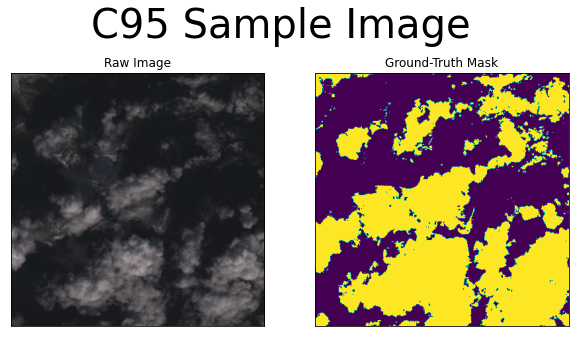

In [5]:
fig, ax = plt.subplots(1,2, figsize=(10,9))
plt.suptitle('C95 Sample Image',
                    fontsize = '40',
                    y = 0.8)

ax[0].imshow(data.open_as_array(77))
ax[0].set_title('Raw Image')
ax[0].get_xaxis().set_visible(False)
ax[0].get_yaxis().set_visible(False)

ax[1].imshow(data.open_mask(77))
ax[1].set_title('Ground-Truth Mask')
ax[1].get_xaxis().set_visible(False)
ax[1].get_yaxis().set_visible(False)

# plt.tight_layout()

# Load Network

In [6]:
unet = UNET(4,2) # 4 channels in (R/G/B/NIR) with 2 channels out (Cloud or no)

# unet.load_state_dict(torch.load('../input/weights/d95_e80_aug.pt'))
dev = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f' Running on {dev} ')


 Running on cuda:0 


# Define training regime

In [7]:
def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=1):
    start = time.time()
    model.to(dev) # send the model to the device if it is available

    train_loss, valid_loss, train_acc ,   valid_acc  = [] , [] , [] , [] # look at training and validation los

    best_acc = 0.0 # set best accuracy

    for epoch in range(epochs): # for the specified number of epochs
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10) 

        for phase in ['train', 'valid']:
            if phase == 'train': 
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl # load in the training datasets
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl # load in the validation datasets

            # set losses and accuracies to 0 
            running_loss = 0.0 
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.to(dev)
                y = y.to(dev)
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size

                if step % 100 == 0:
                    clear_output(wait=True)
                    # print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())

            # loss and accuracy by the epoch
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)
            # epoch_acc = round(epoch_acc*100 , 3 )

            
            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            # Store the stats in a string of tensors
            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)
            train_acc.append(epoch_acc) if phase=='train' else valid_acc.append(epoch_acc)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    torch.save(model.state_dict(), 'UNET_Raw_Weights.pth')

    
    return train_loss, valid_loss , train_acc , valid_acc    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.to(dev)).float().mean()

# Run the Network

In [8]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(unet.parameters(), lr= learning_rate )

train_loss, valid_loss, train_acc , valid_acc = train(unet,     train_dl, valid_dl, loss_fn, opt, acc_metric, epochs = epochs)

Epoch 59/59
----------
valid Loss: 0.1139 Acc: 0.9544434547424316
----------
Training complete in 402m 30s


# Evaluate Results

## Convert tesnors to arrays for plotting

In [21]:
# Training accuracy
t_acc = np.zeros(len(train_acc))
for i , r in enumerate(train_acc):
    t_acc[i] = np.asarray(train_acc[i].cpu())

# validation accuracy
v_acc = np.zeros(len(valid_acc))
for i , r in enumerate(valid_acc):
    v_acc[i] = np.asarray(valid_acc[i].cpu())

# Training Loss
t_loss = np.zeros(len(train_loss))
for i , r in enumerate(train_loss):
    t_loss[i] = np.asarray(train_loss[i].detach().cpu())
    
# Validation Loss
v_loss = np.zeros(len(valid_loss))
for i , r in enumerate(valid_loss):
    v_loss[i] = np.asarray(valid_loss[i].cpu())

# Save Results in dictionary
dict = {
    'Training Accuracy' : t_acc,
    'Validation Accuracy' : v_acc,
    'Training Loss' : t_loss,
    'Validation Loss' : v_loss,
}

df = pd.DataFrame(dict)
df.to_csv('Results/Raw_Unet_Metrics.csv')

## Plot Accuracy and Loss

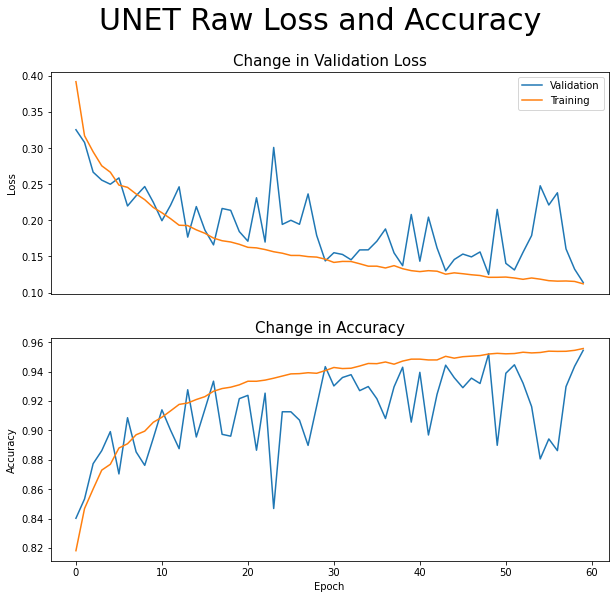

In [10]:
fig, ax = plt.subplots(2,1, figsize=(10,9))
plt.suptitle('UNET Raw Loss and Accuracy',
                    fontsize = '30',
                    # y = 1,
                    )

ax[0].plot(v_loss, label='Validation')
ax[0].plot(t_loss, label='Training')
ax[0].set_title('Change in Validation Loss', fontsize = '15')
ax[0].get_xaxis().set_visible(False)
ax[0].set_ylabel('Loss')
ax[0].legend()

ax[1].plot(v_acc, label='Validation')
ax[1].plot(t_acc, label='Training')
ax[1].set_title('Change in Accuracy' , fontsize = '15')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Accuracy')
# ax[1].legend()

plt.show()

# Visualize the results

In [11]:
# Transfer the batch to images
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

# Predictions to of
def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = unet(xb.to(dev))
predb.shape

torch.Size([16, 2, 384, 384])

# Visualize 3 Samples

In [19]:
# bs = 16
# fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
# for i in range(bs):
#     ax[i,0].imshow(batch_to_img(xb,i))
#     ax[i,1].imshow(yb[i])
#     ax[i,2].imshow(predb_to_mask(predb, i))

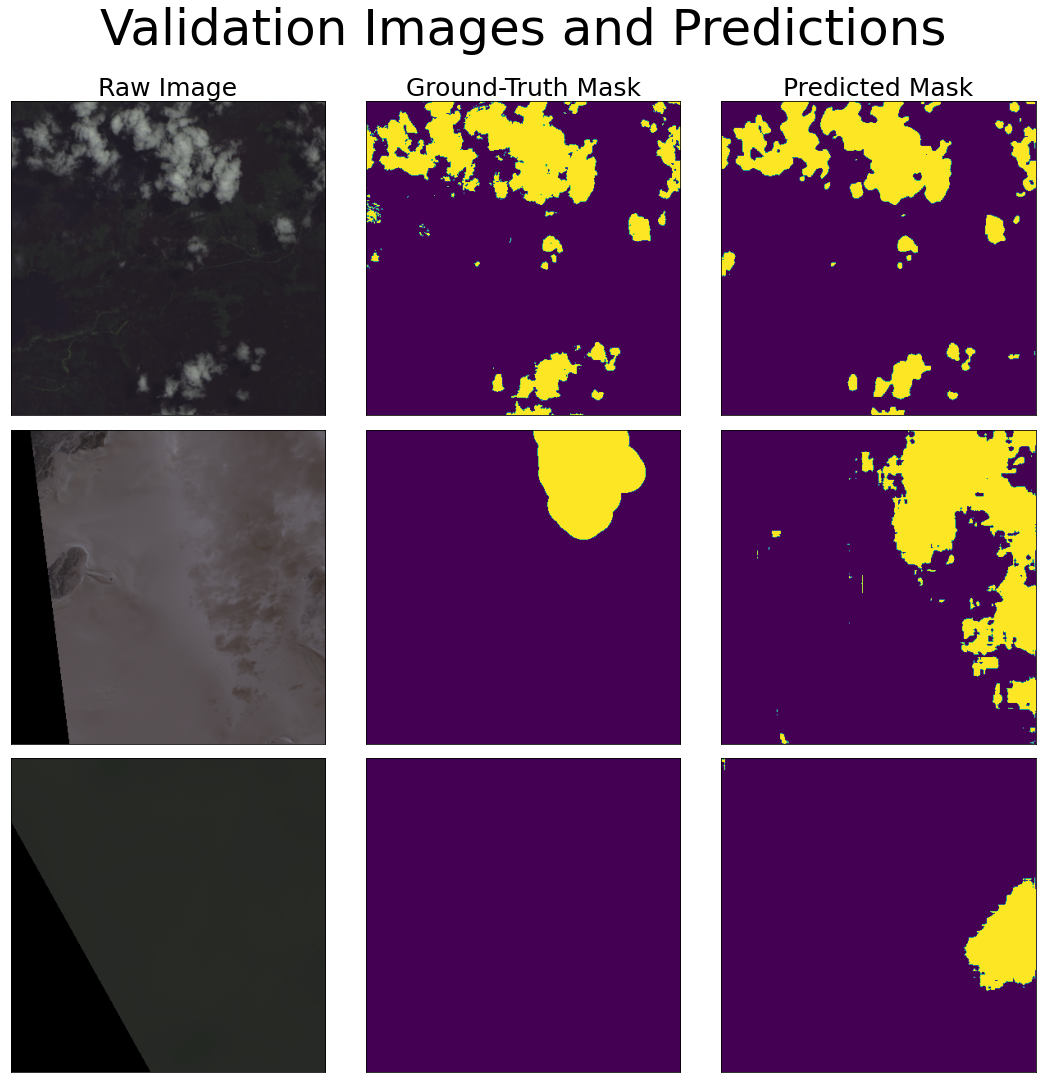

In [18]:
bs = [6 , 14 , 12 ]
fig, ax = plt.subplots( 3 , 3 , figsize=(15,15))
for r , i in enumerate(bs):
    ax[r,0].imshow(batch_to_img(xb,i))
    ax[r,0].get_xaxis().set_visible(False)
    ax[r,0].get_yaxis().set_visible(False)
    
    ax[r,1].imshow(yb[i])
    ax[r,1].get_xaxis().set_visible(False)
    ax[r,1].get_yaxis().set_visible(False)
    
    ax[r,2].imshow(predb_to_mask(predb, i))
    ax[r,2].get_xaxis().set_visible(False)
    ax[r,2].get_yaxis().set_visible(False)

# Labels and adjustments
column_text = '25' # text size for labels
ax[0,0].set_title('Raw Image', fontsize = column_text)
ax[0,1].set_title('Ground-Truth Mask', fontsize = column_text)
ax[0,2].set_title('Predicted Mask', fontsize = column_text)

plt.suptitle('Validation Images and Predictions',  # Set the overall title
    fontsize = 50,# Fontsize
    y = 1)  # Title position
    
plt.tight_layout()
plt.show()